<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W2/ungraded_labs/C3_W2_Lab_1_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a binary classifier with the IMDB Reviews Dataset

In this lab, you will be building a sentiment classification model to distinguish between positive and negative movie reviews. You will train it on the [IMDB Reviews](http://ai.stanford.edu/~amaas/data/sentiment/) dataset and visualize the word embeddings generated after training.

Let's get started!


## Download the Dataset

First, you will need to fetch the dataset you will be working on. This is hosted via [Tensorflow Datasets](https://www.tensorflow.org/datasets), a collection of prepared datasets for machine learning. If you're running this notebook on your local machine, make sure to have the [`tensorflow-datasets`](https://pypi.org/project/tensorflow-datasets/) package installed before importing it. You can install it via `pip` as shown in the commented cell below.

In [ ]:
# Install this package if running on your local machine
# !pip install -q tensorflow-datasets

The [`tfds.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method downloads the dataset into your working directory. You can set the `with_info` parameter to `True` if you want to see the description of the dataset. The `as_supervised` parameter, on the other hand, is set to load the data as `(input, label)` pairs.

In [ ]:
import tensorflow_datasets as tfds

# Load the IMDB Reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [ ]:
# Print information about the dataset
print(info)

As you can see in the output above, there is a total of 100,000 examples in the dataset and it is split into `train`, `test` and `unsupervised` sets. For this lab, you will only use `train` and `test` sets because you will need labeled examples to train your model.

## Split the dataset

If you try printing the `imdb` dataset that you downloaded earlier, you will see that it contains the dictionary that points to [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects. You will explore more of this class and its API in Course 4 of this specialization. For now, you can just think of it as a collection of examples.

In [ ]:
# Print the contents of the dataset you downloaded
print(imdb)

You can preview the raw format of a few examples by using the [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method and iterating over it as shown below:

In [ ]:
# Take 2 training examples and print its contents
for example in imdb['train'].take(2):
  print(example)

You can see that each example is a 2-element tuple of tensors containing the text first, then the label (shown in the `numpy()` property). The next cell below will take all the `train` and `test` sentences and labels into separate lists so you can preprocess the text and feed it to the model later.

In [ ]:
import numpy as np

# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


## Generate Padded Sequences

Now you can do the text preprocessing steps you've learned last week. You will tokenize the sentences and pad them to a uniform length. We've separated the parameters into its own code cell below so it will be easy for you to tweak it later if you want.

In [ ]:
# Parameters

vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)


## Build and Compile the Model

With the data already preprocessed, you can proceed to building your sentiment classification model. The input will be an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. The main idea here is to represent each word in your vocabulary with vectors. These vectors have trainable weights so as your neural network learns, words that are most likely to appear in a positive tweet will converge towards similar weights. Similarly, words in negative tweets will be clustered more closely together. You can read more about word embeddings [here](https://www.tensorflow.org/text/guide/word_embeddings).

After the `Embedding` layer, you will flatten its output and feed it into a `Dense` layer. You will explore other architectures for these hidden layers in the next labs.

The output layer would be a single neuron with a sigmoid activation to distinguish between the 2 classes. As is typical with binary classifiers, you will use the `binary_crossentropy` as your loss function while training.

In [ ]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

## Train the Model

Next, of course, is to train your model. With the current settings, you will get near perfect training accuracy after just 5 epochs but the validation accuracy will plateau at around 83%. See if you can still improve this by adjusting some of the parameters earlier (e.g. the `vocab_size`, number of `Dense` neurons, number of epochs, etc.).

In [ ]:
num_epochs = 10

# Train the model
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

## Visualize Word Embeddings

After training, you can visualize the trained weights in the `Embedding` layer to see words that are clustered together. The [Tensorflow Embedding Projector](https://projector.tensorflow.org/) is able to reduce the 16-dimension vectors you defined earlier into fewer components so it can be plotted in the projector. First, you will need to get these weights and you can do that with the cell below:

In [ ]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

You will need to generate two files:

* `vecs.tsv` - contains the vector weights of each word in the vocabulary
* `meta.tsv` - contains the words in the vocabulary

For this, it is useful to have `reverse_word_index` dictionary so you can quickly lookup a word based on a given index. For example, `reverse_word_index[1]` will return your OOV token because it is always at index = 1. Fortunately, the `Tokenizer` class already provides this dictionary through its `index_word` property. Yes, as the name implies, it is the reverse of the `word_index` property which you used earlier!

In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

Now you can start the loop to generate the files. You will loop `vocab_size-1` times, skipping the `0` key because it is just for the padding.

In [ ]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

When running this on Colab, you can run the code below to download the files. Otherwise, you can see the files in your current working directory and download it manually.


In [ ]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

Now you can go to the [Tensorflow Embedding Projector](https://projector.tensorflow.org/) and load the two files you downloaded to see the visualization. You can search for words like `worst` and `fantastic` and see the other words closely located to these.

## Wrap Up

In this lab, you were able build a simple sentiment classification model and train it on preprocessed text data. In the next lessons, you will revisit the Sarcasm Dataset you used in Week 1 and build a model to train on it.

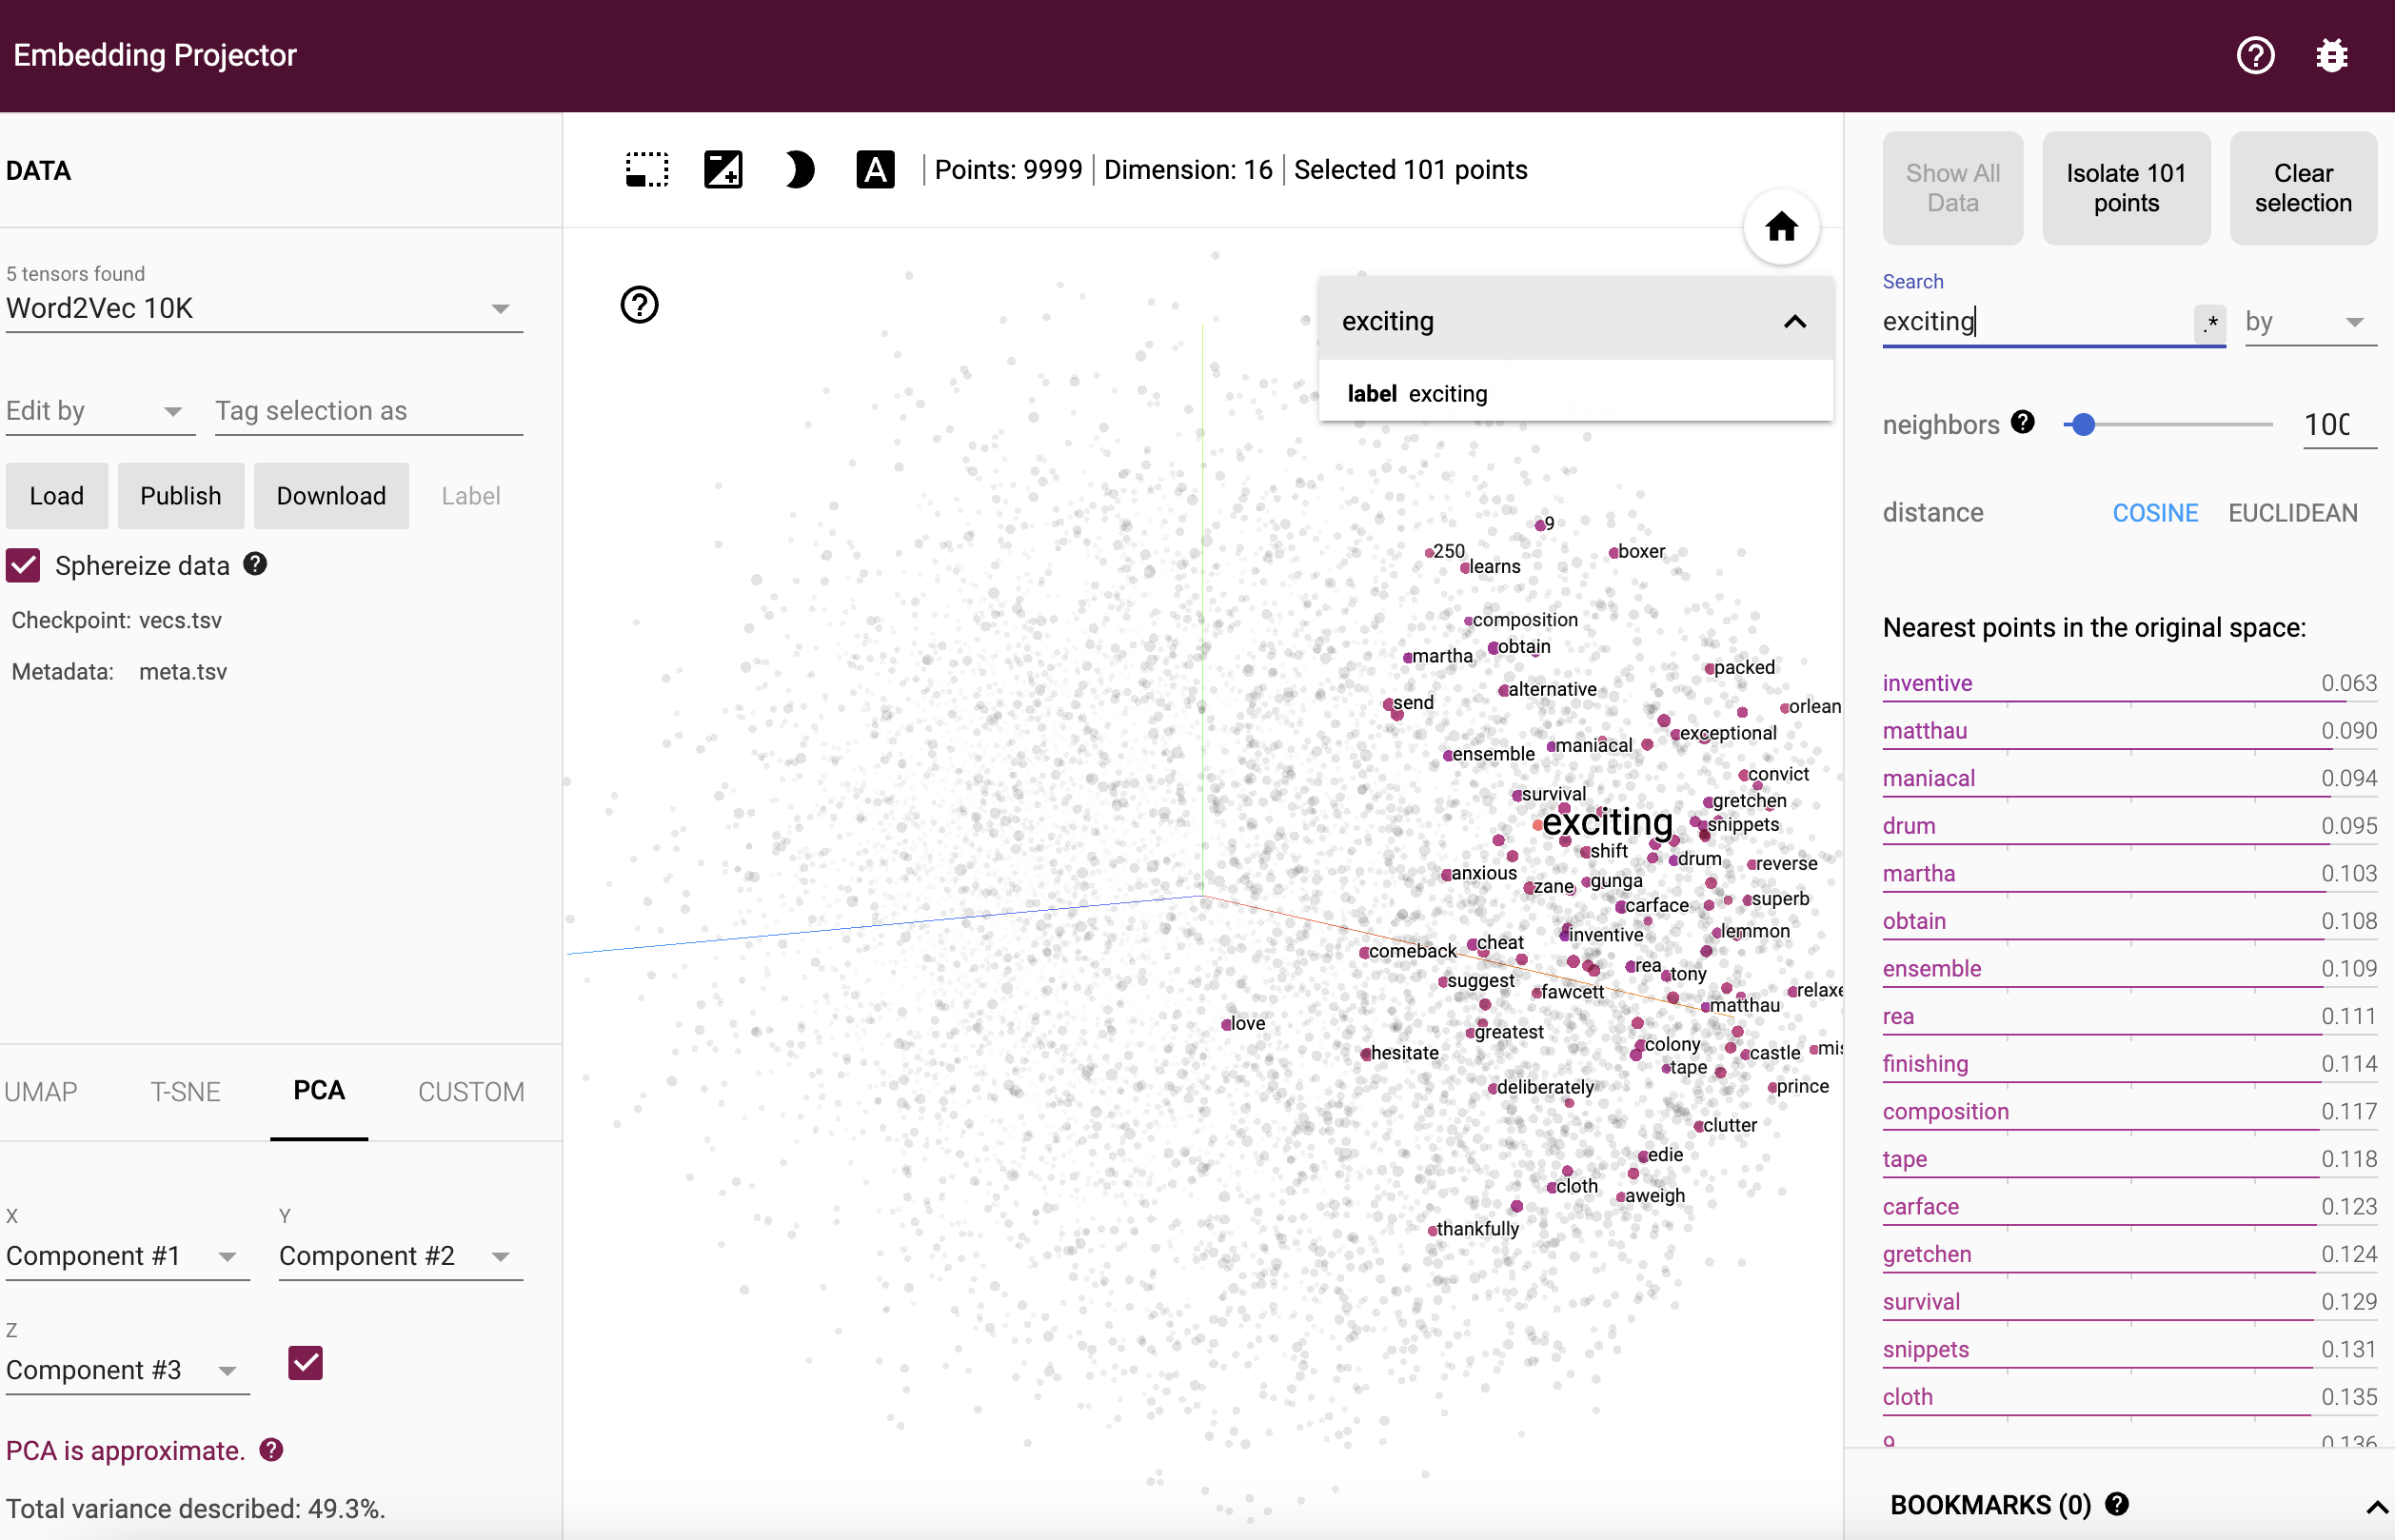

- 이런 식으로 확인할 수 있다